# Exploratory Data Analysis (EDA) for ATM Cash Demand Forecasting
Before training models, we first explore and visualize the raw ATM dataset to understand its structure, patterns, and potential issues. This step helps us identify trends, correlations, seasonality, and anomalies in the data.
**In this section, we will:**
* Check the distribution of cash demand (withdrawals, deposits, next-day demand).
* Explore the impact of time-related features (day of week, time of day, holidays, special events).
* Compare cash demand across ATM locations and types.
* Examine external factors like weather conditions and nearby competitor ATMs.
* Detect potential outliers or missing values that may affect model training.
* These insights guide our feature engineering and improve the quality of our forecasting models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure plots display nicely
#plt.style.use("seaborn-v0_8")
#sns.set_palette("Set2")

# Set style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
df=pd.read_csv('/kaggle/input/atm-cash-demand-forecasting-and-management/atm_cash_management_dataset.csv')
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

Dataset shape: (5658, 13)

Missing values:
 ATM_ID                     0
Date                       0
Day_of_Week                0
Time_of_Day                0
Total_Withdrawals          0
Total_Deposits             0
Location_Type              0
Holiday_Flag               0
Special_Event_Flag         0
Previous_Day_Cash_Level    0
Weather_Condition          0
Nearby_Competitor_ATMs     0
Cash_Demand_Next_Day       0
dtype: int64


In [4]:
df.head()

,ATM_ID,Date,Day_of_Week,Time_of_Day,Total_Withdrawals,Total_Deposits,Location_Type,Holiday_Flag,Special_Event_Flag,Previous_Day_Cash_Level,Weather_Condition,Nearby_Competitor_ATMs,Cash_Demand_Next_Day
0,ATM_0041,2022-04-25,Monday,Morning,57450,9308,Standalone,0,0,112953,Rainy,5,44165
1,ATM_0007,2023-11-24,Friday,Morning,72845,17896,Supermarket,0,0,115348,Clear,0,41249
2,ATM_0014,2022-08-27,Saturday,Morning,42957,12712,Supermarket,0,0,90731,Cloudy,1,29901
3,ATM_0029,2023-08-27,Sunday,Evening,43014,1375,Mall,0,0,88754,Rainy,5,44155
4,ATM_0028,2022-12-15,Thursday,Evening,36379,2938,Bank Branch,0,0,129312,Snowy,0,29784


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5658 entries, 0 to 5657
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ATM_ID                   5658 non-null   object        
 1   Date                     5658 non-null   datetime64[ns]
 2   Day_of_Week              5658 non-null   object        
 3   Time_of_Day              5658 non-null   object        
 4   Total_Withdrawals        5658 non-null   int64         
 5   Total_Deposits           5658 non-null   int64         
 6   Location_Type            5658 non-null   object        
 7   Holiday_Flag             5658 non-null   int64         
 8   Special_Event_Flag       5658 non-null   int64         
 9   Previous_Day_Cash_Level  5658 non-null   int64         
 10  Weather_Condition        5658 non-null   object        
 11  Nearby_Competitor_ATMs   5658 non-null   int64         
 12  Cash_Demand_Next_Day     5658 non-

## 1. Univariate Analysis

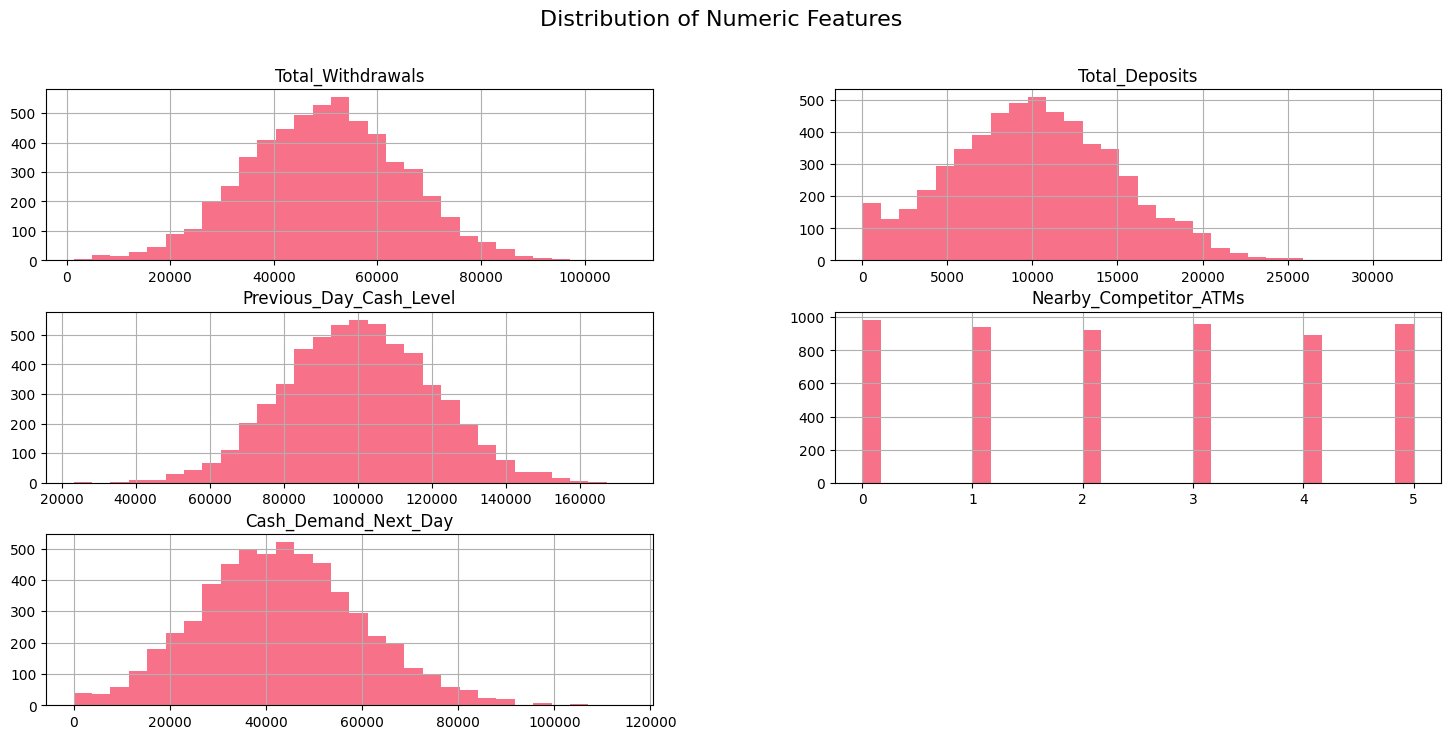

In [6]:
# --- Distribution of numeric features ---
numeric_cols = ["Total_Withdrawals", "Total_Deposits","Previous_Day_Cash_Level", "Nearby_Competitor_ATMs", "Cash_Demand_Next_Day"]
df[numeric_cols].hist(bins=30, figsize=(18, 8))
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()

* #### **Observation:**
    * Key variables (withdrawals, deposits, cash demand) all show normal-like distributions, which is favorable for many ML models.
    * Withdrawals dominate deposits, which aligns with ATM real-world behavior.
    * Previous day’s cash level seems tightly distributed, suggesting cash refilling policies keep it in a controlled range.
    * Competitor ATMs is categorical/discrete and well balanced — this may serve as a strong explanatory factor.
    * Target variable (Cash_Demand_Next_Day) looks stable and predictable, with limited outliers — good sign for forecasting.

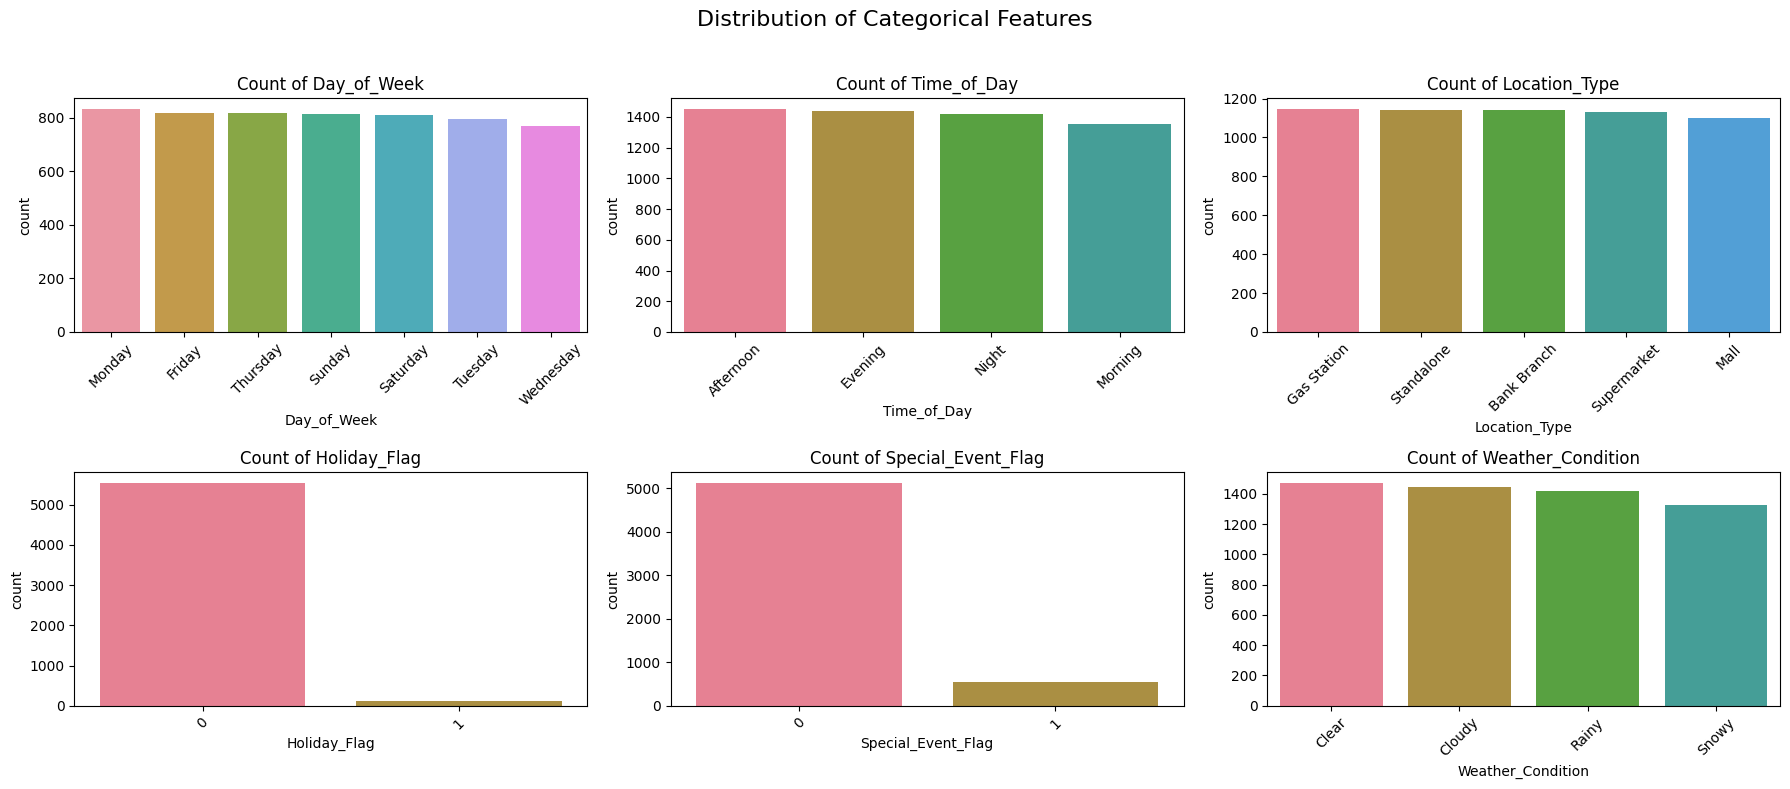

In [7]:
# --- Distribution of Categorical features ---
categorical_cols = ["Day_of_Week", "Time_of_Day", "Location_Type", 
                    "Holiday_Flag", "Special_Event_Flag", "Weather_Condition"]

# Create subplots for all categorical features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Count of {col}")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Distribution of Categorical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


* #### **Observation:**
     * Most categorical variables (Day_of_Week, Time_of_Day, Location_Type, Weather_Condition) are well balanced, which is ideal for modeling since the model can learn patterns without bias toward one category.
     * Holiday_Flag and Special_Event_Flag are highly imbalanced, with very few positive cases. While rare, these categories are important since they may cause unusual spikes in demand. They will require careful handling (e.g., resampling, weighting, or treating as anomaly drivers).
     * Features like Day_of_Week and Time_of_Day will help capture seasonal and temporal patterns, while Location_Type and Weather_Condition provide contextual drivers of demand.
  Conclusion: The categorical features give good coverage of temporal, locational, and environmental factors. Most are balanced and useful, but holidays and special events — though rare — could be critical in explaining extreme demand variations.

## 2. Bivariate Analysis with Target

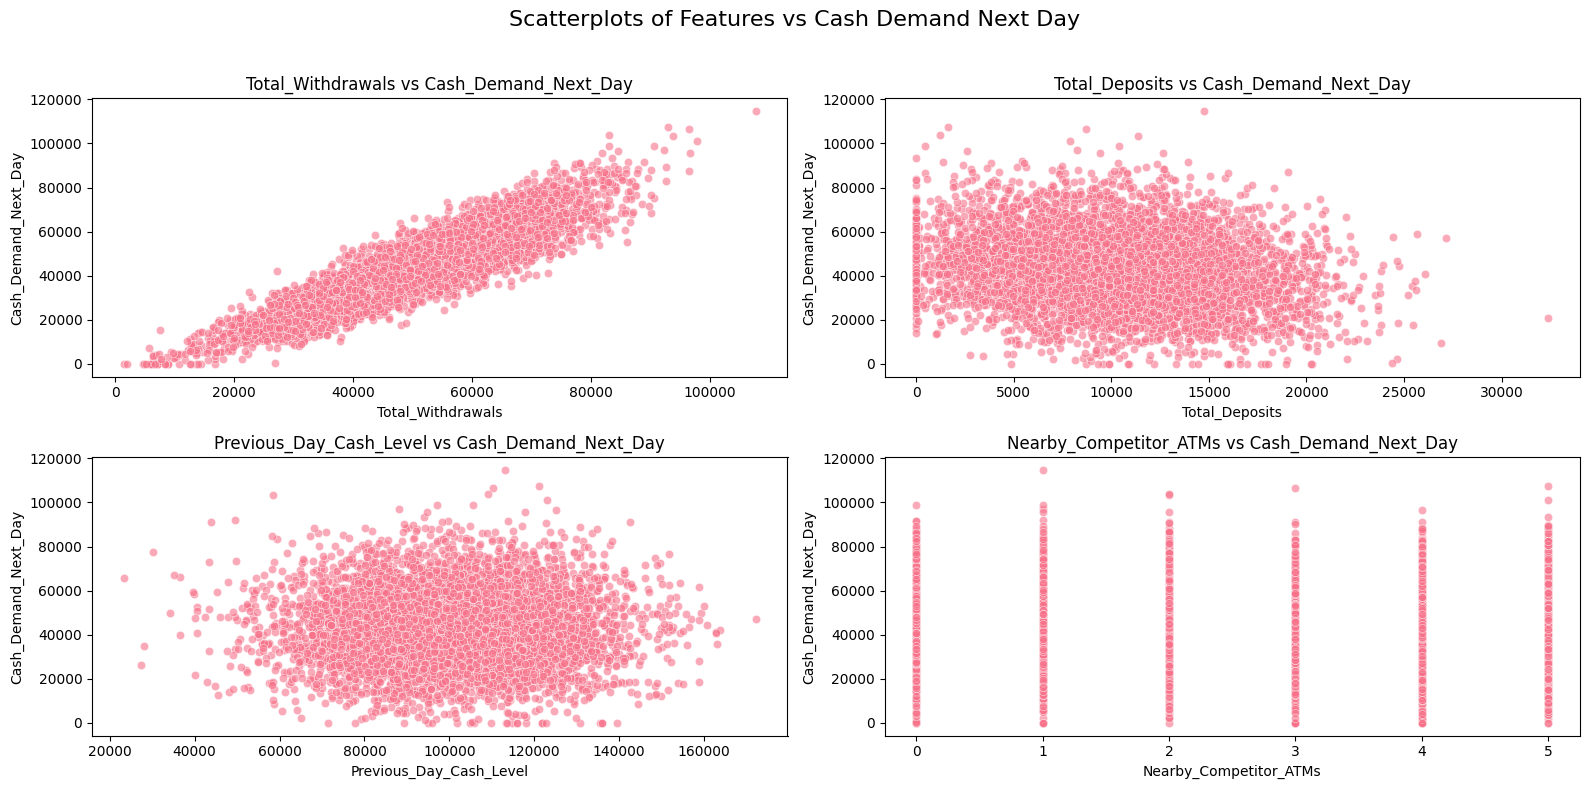

In [8]:
# Numeric vs Target (scatter + correlation)
num_cols = ["Total_Withdrawals", "Total_Deposits", 
            "Previous_Day_Cash_Level", "Nearby_Competitor_ATMs"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.scatterplot(data=df, x=col, y="Cash_Demand_Next_Day", alpha=0.6, ax=axes[i])
    axes[i].set_title(f"{col} vs Cash_Demand_Next_Day")

plt.suptitle("Scatterplots of Features vs Cash Demand Next Day", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




* #### **Observation:**
    * Total_Withdrawals shows a very strong positive linear correlation with next-day cash demand. This is the most influential feature and a direct driver of the target.
    * Total_Deposits has little to no clear relationship with next-day demand, suggesting deposits are not a strong predictor.
    * Previous_Day_Cash_Level shows a weak positive trend but with high variability, meaning it adds some context but is not a primary driver.
    * Nearby_Competitor_ATMs does not display a clear trend, but competition levels may still act as a secondary factor when combined with other features.
 Conclusion: Withdrawals are the dominant predictor of next-day demand, while deposits and competitors carry weak signal, and previous-day cash level offers supportive but noisy context.

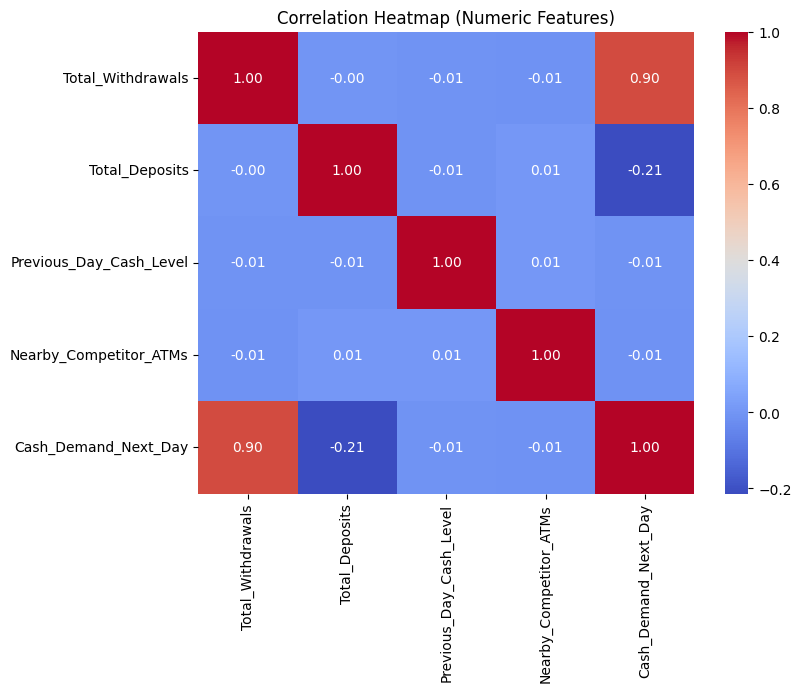

In [9]:
# Correlation heatmap
plt.figure(figsize=(8,6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

* #### **Observation:**
   * Strong positive correlation: Total Withdrawals and Cash Demand Next Day show a very strong correlation (0.90), which makes intuitive sense as higher withdrawal activity likely predicts higher future demand.
   * Negative relationship: Total Deposits shows a moderate negative correlation (-0.21) with Cash Demand Next Day, suggesting that high deposit activity might indicate lower future cash demand.
   * Weak relationships: Previous Day Cash Level, Nearby Competitor ATMs, and other variables show very weak correlations (near 0.00-0.01) with the target variable, indicating these factors have minimal linear relationship with cash demand.
   * Independence: Most variables appear relatively independent of each other, which is beneficial for modeling as it suggests low multicollinearity.

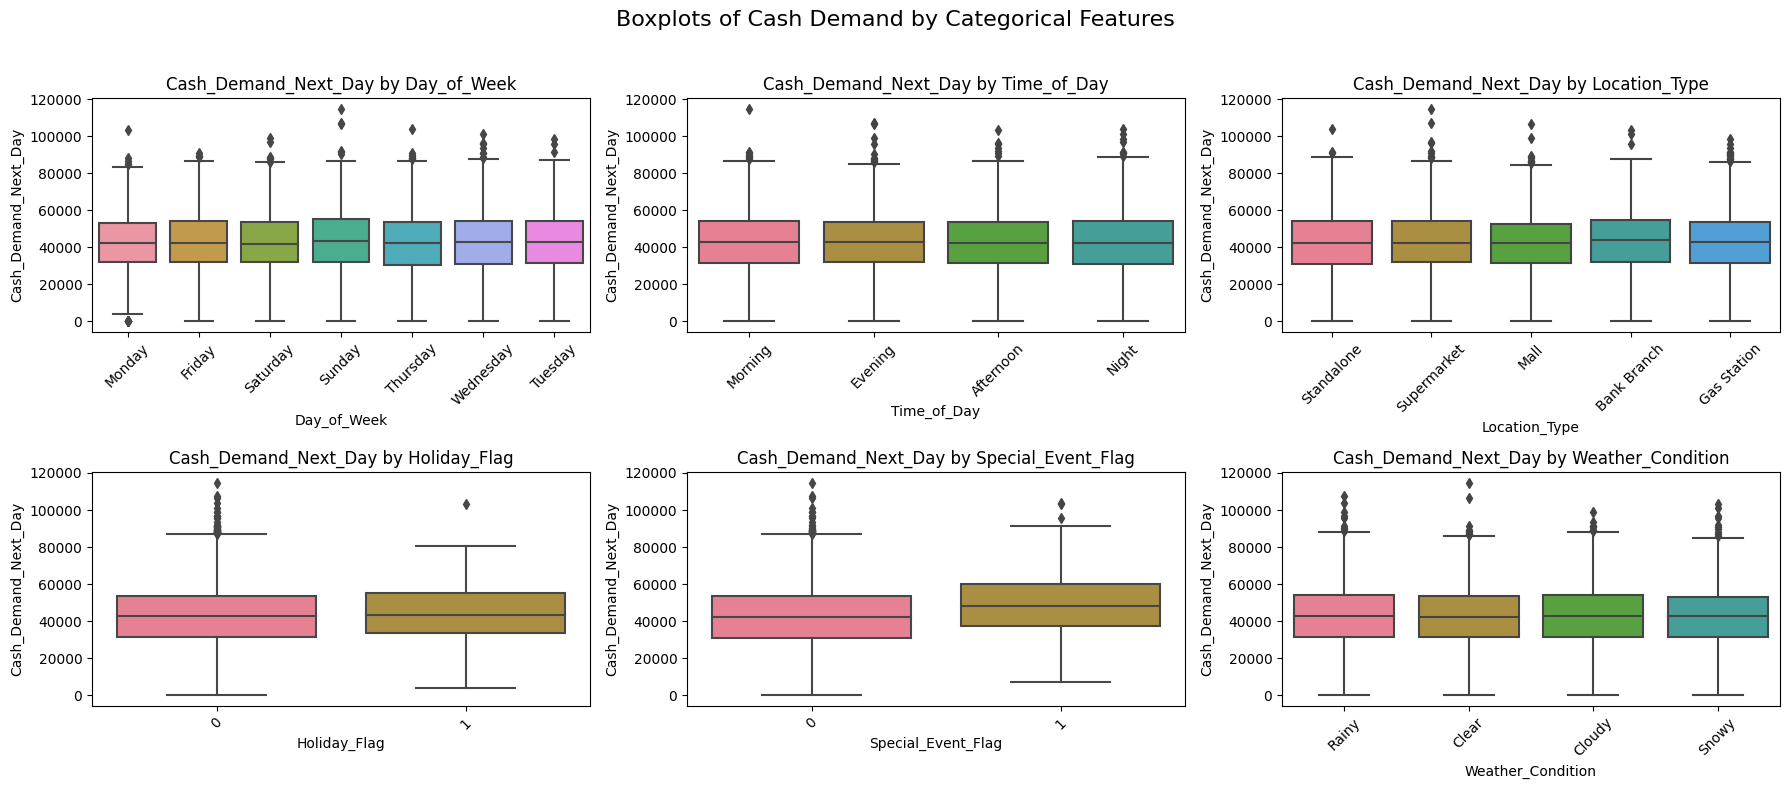

In [10]:
# Categorical vs Target (boxplots)
categorical_cols = ["Day_of_Week", "Time_of_Day", "Location_Type", "Holiday_Flag", "Special_Event_Flag", "Weather_Condition"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.boxplot(data=df, x=col, y="Cash_Demand_Next_Day", ax=axes[i])
    axes[i].set_title(f"Cash_Demand_Next_Day by {col}")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Boxplots of Cash Demand by Categorical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



* #### **Observation:**
     * Temporal patterns: Cash demand remains remarkably consistent across days of the week and times of day, with median values hovering around 40,000-50,000 and similar distributions. This suggests that ATM usage doesn't vary dramatically by when people access them.
     * Location influence: Different location types (Standalone, Supermarket, Mall, Bank Branch, Gas Station) show subtle but noticeable differences in cash demand patterns, with some locations having slightly higher median demands.
     * Event-driven demand: The binary variables (Holiday Flag and Special Event Flag) show clear differences - both holidays and special events appear to drive higher cash demand, with the "1" (event present) categories showing elevated median values and wider distributions.
     * Weather impact: Weather conditions show relatively similar patterns across Rainy, Clear, Cloudy, and Snowy conditions, though there may be slight variations in the upper quartiles.

## 3. Time-Series Analysis

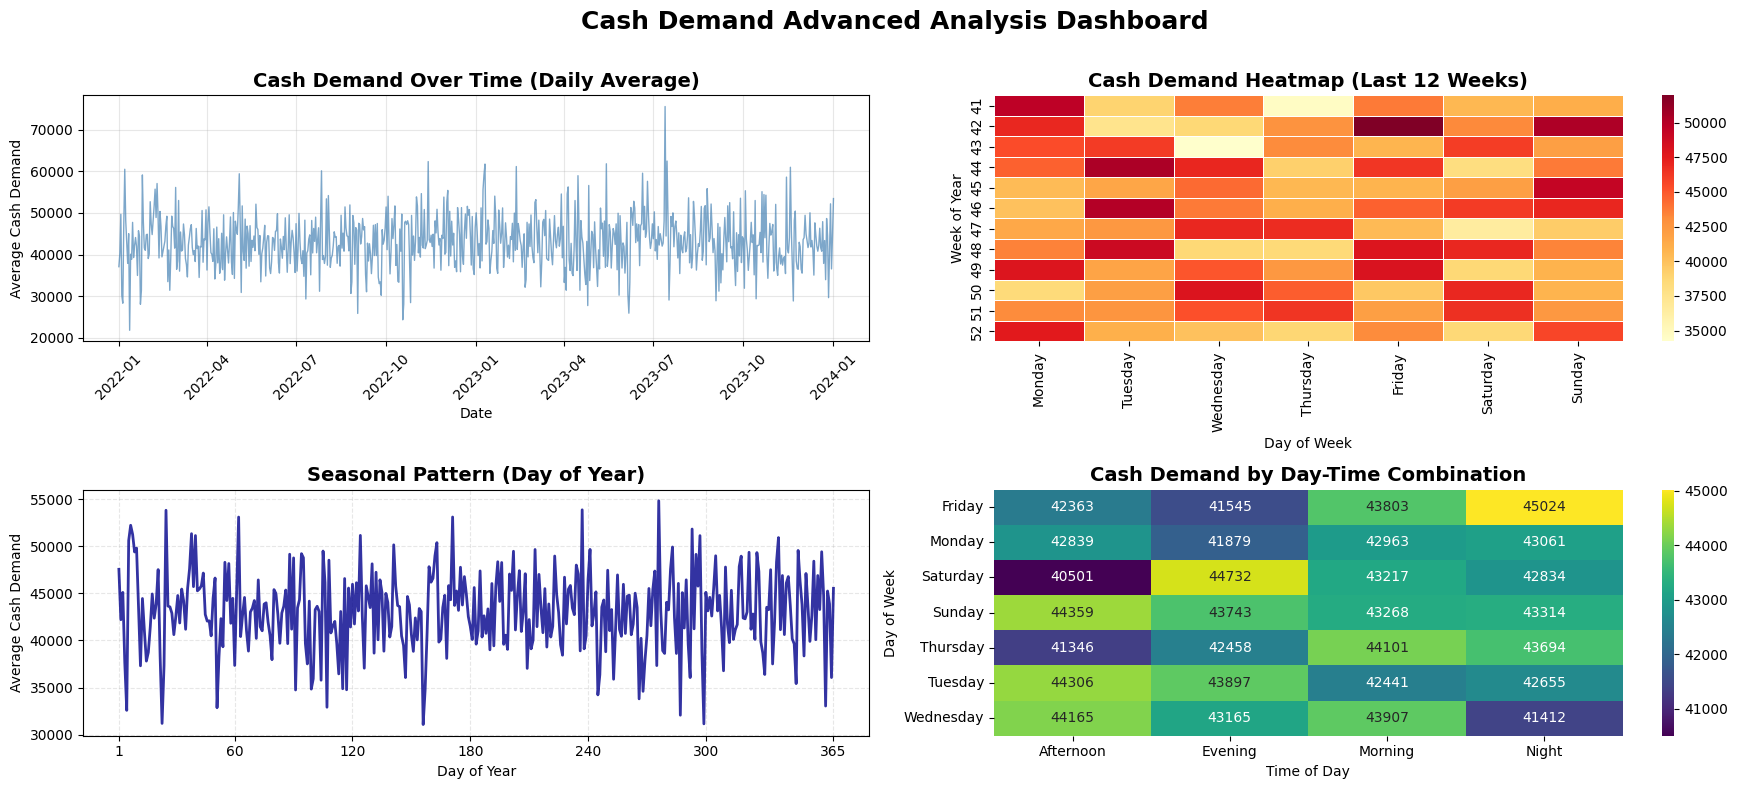

In [11]:
df_temp = df.copy()
df_temp['Year'] = df_temp['Date'].dt.year
df_temp['Month'] = df_temp['Date'].dt.month
df_temp['Day'] = df_temp['Date'].dt.day
df_temp['Quarter'] = df_temp['Date'].dt.quarter
df_temp['Week_of_Year'] = df_temp['Date'].dt.isocalendar().week
df_temp['Month_Name'] = df_temp['Date'].dt.month_name()
df_temp['Is_Weekend'] = df_temp['Day_of_Week'].isin(['Saturday', 'Sunday'])

# Weekday order
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create figure with 2×2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))
axes = axes.flatten()

# 1. Cash Demand Over Time (Daily Average)
daily_demand = df_temp.groupby('Date')['Cash_Demand_Next_Day'].mean().reset_index()
axes[0].plot(daily_demand['Date'], daily_demand['Cash_Demand_Next_Day'], alpha=0.7, linewidth=1, color="steelblue")
axes[0].set_title('Cash Demand Over Time (Daily Average)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Average Cash Demand')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# 2. Weekly Pattern Heatmap (last 12 weeks)
weekly_pattern = df_temp.pivot_table(
    values='Cash_Demand_Next_Day', 
    index='Week_of_Year', 
    columns='Day_of_Week', 
    aggfunc='mean'
)
if all(day in weekly_pattern.columns for day in dow_order):
    weekly_pattern = weekly_pattern[dow_order]

sns.heatmap(weekly_pattern.iloc[-12:], cmap='YlOrRd', cbar=True,
            linewidths=0.5, ax=axes[1])
axes[1].set_title('Cash Demand Heatmap (Last 12 Weeks)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Week of Year')

# 3. Seasonal Pattern (Day of Year)
df_temp['Day_of_Year'] = df_temp['Date'].dt.dayofyear
seasonal_demand = df_temp.groupby('Day_of_Year')['Cash_Demand_Next_Day'].mean().reset_index()

axes[2].plot(seasonal_demand['Day_of_Year'], seasonal_demand['Cash_Demand_Next_Day'], 
             color='darkblue', linewidth=2, alpha=0.8)
axes[2].set_title('Seasonal Pattern (Day of Year)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Day of Year')
axes[2].set_ylabel('Average Cash Demand')
axes[2].grid(True, alpha=0.3, linestyle='--')
axes[2].set_xticks([1, 60, 120, 180, 240, 300, 365])  # quarterly markers

# 4. Day-Hour Combination Heatmap
day_time_demand = df_temp.groupby(['Day_of_Week', 'Time_of_Day'])['Cash_Demand_Next_Day'].mean().reset_index()
day_time_pivot = day_time_demand.pivot(index='Day_of_Week', columns='Time_of_Day', values='Cash_Demand_Next_Day')

if not day_time_pivot.empty:
    sns.heatmap(day_time_pivot, annot=True, cmap='viridis', fmt='.0f', cbar=True, ax=axes[3])
    axes[3].set_title('Cash Demand by Day-Time Combination', fontsize=14, fontweight='bold')
    axes[3].set_xlabel('Time of Day')
    axes[3].set_ylabel('Day of Week')

# Adjust layout
plt.suptitle("Cash Demand Advanced Analysis Dashboard", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


* #### **Observation:**
  * Forecasting Strategy: Seasonal patterns are more predictable than daily patterns - focus on holiday/seasonal adjustments rather than day-of-week optimization
  * Cash Management: Plan for high volatility in daily demand but leverage seasonal predictability for inventory planning
  * Operational Focus: Weekend operations (especially Friday nights, Saturday afternoons) need higher cash availability
  * Risk Management: The wide daily variance (25k-65k range) requires robust cash buffer strategies
  * External Factors: The lack of strong day-of-week patterns suggests external events, weather, and economic conditions are primary demand drivers rather than routine behavioral patterns
This data suggests a mature ATM network where seasonal and event-driven factors outweigh routine usage patterns in determining cash demand.

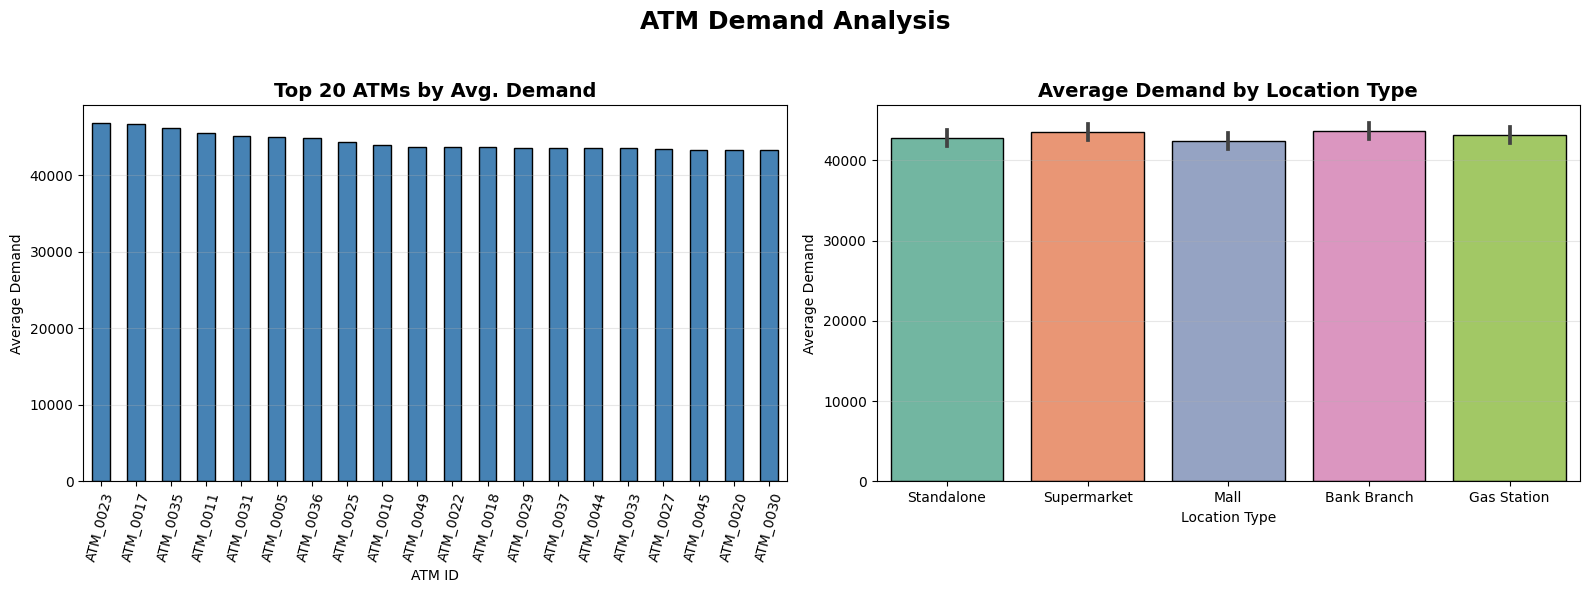

In [12]:
# 4. ATM-Level Insights

# Group ATM demand
atm_demand = df.groupby("ATM_ID")["Cash_Demand_Next_Day"].mean().sort_values(ascending=False)

# Create subplot grid (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# 1. Top 20 ATMs by Avg. Demand
atm_demand.head(20).plot(kind="bar", ax=axes[0], color="steelblue", edgecolor="black")
axes[0].set_title("Top 20 ATMs by Avg. Demand", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Average Demand")
axes[0].set_xlabel("ATM ID")
axes[0].tick_params(axis="x", rotation=75)
axes[0].grid(True, alpha=0.3, axis="y")

# 2. Location Type Effect
sns.barplot(data=df, x="Location_Type", y="Cash_Demand_Next_Day", 
            estimator=np.mean, ax=axes[1], palette="Set2", edgecolor="black")
axes[1].set_title("Average Demand by Location Type", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Location Type")
axes[1].set_ylabel("Average Demand")
axes[1].grid(True, alpha=0.3, axis="y")

# Adjust layout
plt.suptitle("ATM Demand Analysis", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



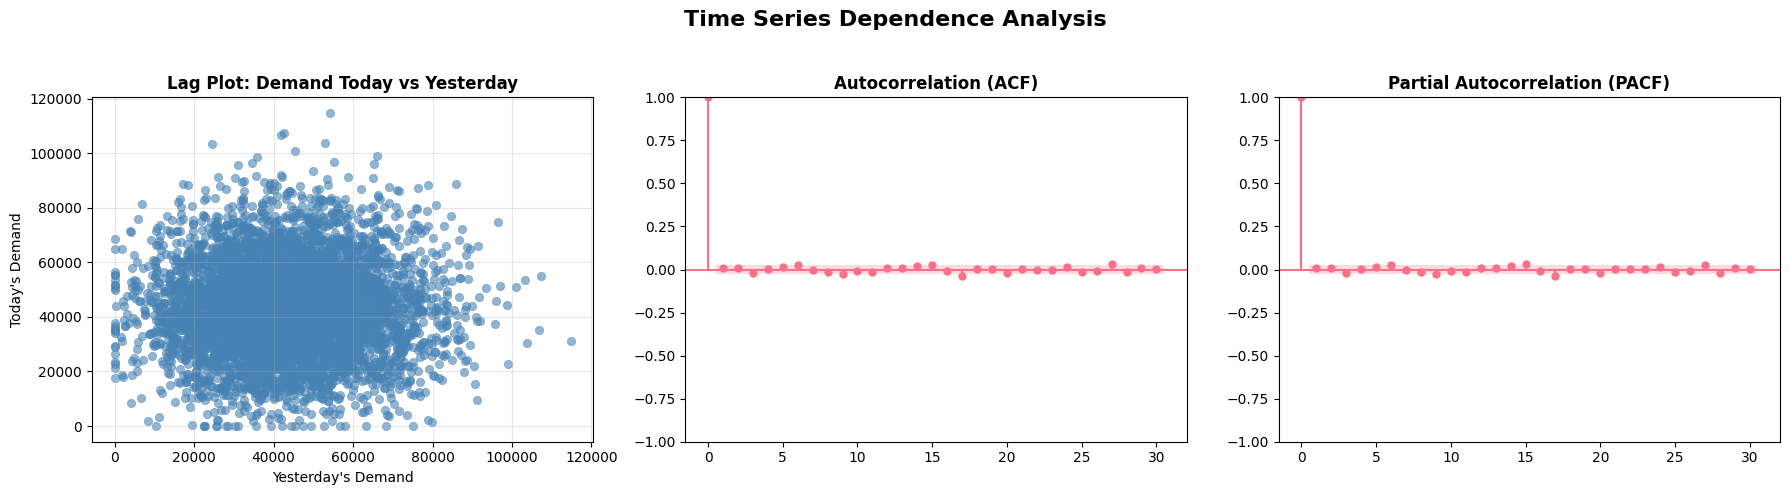

In [13]:
# 5. Advanced (Forecasting Prep)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create lag feature
df["lag1"] = df["Cash_Demand_Next_Day"].shift(1)

# Create subplot grid (1 row, 3 columns)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# 1. Lag Plot
sns.scatterplot(x="lag1", y="Cash_Demand_Next_Day", data=df, ax=axes[0], alpha=0.6, color="steelblue", edgecolor=None)
axes[0].set_title("Lag Plot: Demand Today vs Yesterday", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Yesterday's Demand")
axes[0].set_ylabel("Today's Demand")
axes[0].grid(True, alpha=0.3)

# 2. Autocorrelation (ACF)
plot_acf(df["Cash_Demand_Next_Day"].dropna(), lags=30, ax=axes[1])
axes[1].set_title("Autocorrelation (ACF)", fontsize=12, fontweight="bold")

# 3. Partial Autocorrelation (PACF)
plot_pacf(df["Cash_Demand_Next_Day"].dropna(), lags=30, ax=axes[2])
axes[2].set_title("Partial Autocorrelation (PACF)", fontsize=12, fontweight="bold")

# Adjust layout
plt.suptitle("Time Series Dependence Analysis", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


1. Forecasting Implications:
Traditional time series models (ARIMA, exponential smoothing) will likely perform poorly
External variables (weather, events, economic factors) are more important than historical demand
Machine learning approaches using external features will outperform pure time series methods
2. Business Understanding:
Daily demand independence: Each day's ATM usage is largely independent of previous days
Event-driven demand: External factors (paydays, holidays, weather) drive demand more than usage patterns
No customer habit persistence: People don't seem to develop predictable ATM usage routines
3. Operational Strategy:
Focus on external predictors: Weather forecasts, holiday calendars, local events matter more than historical usage
Maintain flexibility: Can't rely on "yesterday was high, so today will be high" logic
Seasonal planning: While daily patterns are random, seasonal patterns (from previous analysis) remain important
4. Risk Management:
Higher uncertainty: The randomness means wider prediction intervals needed
Safety stock importance: Since demand is unpredictable day-to-day, maintaining adequate cash reserves is crucial
Real-time monitoring: Need responsive systems since historical patterns don't provide early warning
5. Model Selection:
This analysis suggests that ensemble methods combining external variables (weather, events, location features) will be most effective, rather than traditional time series approaches that rely on historical patterns. The cash demand behaves more like a cross-sectional prediction problem than a traditional time series forecasting challenge.

In [14]:
#best numeric features
corr = df.corr(numeric_only=True)["Cash_Demand_Next_Day"].sort_values(ascending=False)
print(corr)


Cash_Demand_Next_Day       1.000000
Total_Withdrawals          0.895053
Special_Event_Flag         0.117524
Holiday_Flag               0.019698
lag1                       0.010661
Previous_Day_Cash_Level   -0.005849
Nearby_Competitor_ATMs    -0.014231
Total_Deposits            -0.213557
Name: Cash_Demand_Next_Day, dtype: float64


In [15]:
df.groupby("Day_of_Week")["Cash_Demand_Next_Day"].mean().sort_values()

Day_of_Week
Monday       42650.046931
Saturday     42809.879012
Thursday     42839.079462
Wednesday    43133.503896
Friday       43175.278729
Tuesday      43328.164366
Sunday       43676.686732
Name: Cash_Demand_Next_Day, dtype: float64